#Projeto - ICT Itaú
**Autor:** Nguyen Thi Hoang Yen
**Trilha:** A – Dados & IA  
**Tarefa:** Criar um pipeline simples de ingestão e processamento de dados (em Python), a partir de dados públicos de custo de nuvem (ex: AWS pricing, Azure calculator API, etc.).  

**Desafio adicional:** Implementar um modelo de machine learning (regressão, clustering ou outro) para prever custos ou identificar padrões de uso.  

**Entrega esperada:**  
- Código-fonte comentado  
- Notebook com explicação do pipeline  
- Print ou gráfico do resultado do modelo  
- Arquivo `.csv` com os dados tratados e resultados  
---


## 🚀 Pipeline de Ingestão e Processamento de Dados de Custos em Nuvem

### Objetivo
Construir um pipeline que:
1. Faça a **ingestão de dados de máquinas virtuais em nuvem** (Google Cloud, AWS, Azure).  
2. Realize o **processamento e limpeza dos dados** (tratamento de nulos, conversão de tipos, criação de variáveis).  
3. Execute uma **análise exploratória (EDA)** para identificar padrões de custo.  
4. Treine um **modelo de Machine Learning** simples para prever custos.  
5. Gere um **arquivo CSV final** com os dados tratados.  

In [7]:
# =====================================
# 1. Importação das Bibliotecas
# =====================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
# =====================================
# 2. Ingestão de Dados
# =====================================

# Fonte de dados: tipos de máquinas e preços do Google Cloud
url = "https://gcloud-compute.com/machine-types-regions.csv"
df = pd.read_csv(url)

print("Dimensão original:", df.shape)
print("Colunas disponíveis:", df.columns.tolist()[:15], "...")
df.head()


Dimensão original: (9426, 62)
Colunas disponíveis: ['name', 'series', 'family', 'description', 'location', 'region', 'regionLocation', 'regionLocationLong', 'regionLocationCountryCode', 'regionCfe', 'regionCo2Kwh', 'regionLowCo2', 'regionLat', 'regionLng', 'regionPublicIpv4Addr'] ...


,name,series,family,description,location,region,regionLocation,regionLocationLong,regionLocationCountryCode,regionCfe,...,monthSlesSap,monthSlesSap1yCud,monthSlesSap3yCud,monthRhel,monthRhel1yCud,monthRhel3yCud,monthRhelSap,monthRhelSap1yCud,monthRhelSap3yCud,monthWindows
0,c4-highcpu-16,c4,General-purpose,"16 vCPUs, 32 GB RAM",africa,africa-south1,Johannesburg,"Johannesburg, South Africa",ZA,16.0,...,299.3,119.939,107.7480,126.144,126.144,126.144,189.80,189.80,189.80,537.28
1,c4-highcpu-192,c4,General-purpose,"192 vCPUs, 384 GB RAM",africa,africa-south1,Johannesburg,"Johannesburg, South Africa",ZA,16.0,...,299.3,119.939,107.7480,1345.536,1345.536,1345.536,2102.40,2102.40,2102.40,6447.36
2,c4-highcpu-2,c4,General-purpose,"2 vCPUs, 4 GB RAM",africa,africa-south1,Johannesburg,"Johannesburg, South Africa",ZA,16.0,...,124.1,50.005,44.7198,21.024,21.024,21.024,32.85,32.85,32.85,67.16
3,c4-highcpu-24,c4,General-purpose,"24 vCPUs, 48 GB RAM",africa,africa-south1,Johannesburg,"Johannesburg, South Africa",ZA,16.0,...,299.3,119.939,107.7480,189.216,189.216,189.216,284.70,284.70,284.70,805.92
4,c4-highcpu-32,c4,General-purpose,"32 vCPUs, 64 GB RAM",africa,africa-south1,Johannesburg,"Johannesburg, South Africa",ZA,16.0,...,299.3,119.939,107.7480,252.288,252.288,252.288,379.60,379.60,379.60,1074.56


In [9]:
# =====================================
# 3. Seleção de Colunas Relevantes
# =====================================
colunas_relevantes = [
    "name", "series", "family", "location", "region",
    "vCpus", "memoryGB", "hour", "hourSpot", "month", "monthSpot"
]

df_proc = df[colunas_relevantes].copy()
print("Dimensão após seleção:", df_proc.shape)
df_proc.sample(5)


Dimensão após seleção: (9426, 11)


,name,series,family,location,region,vCpus,memoryGB,hour,hourSpot,month,monthSpot
1332,c3-standard-88,c3,General-purpose,asia,asia-south1,88.0,352.0,4.612791,0.757152,3367.337459,552.72096
3227,n2-highcpu-96,n2,General-purpose,europe,europe-southwest1,96.0,96.0,4.060861,0.698976,2372.135967,510.25248
8541,m3-ultramem-128,m3,Memory-optimized,us,us-west1,128.0,3904.0,24.364800,9.705728,17786.304000,7085.18144
5517,m3-ultramem-64,m3,Memory-optimized,me,me-central1,64.0,1952.0,14.801616,1.923392,10805.179680,1404.07616
1802,n2d-standard-48,n2d,General-purpose,asia,asia-south2,48.0,192.0,2.435616,0.577824,1422.755344,421.81152


## 🔧 Processamento dos Dados

Etapas realizadas:
- Conversão de colunas de custo para valores numéricos.
- Imputação de valores ausentes:
  - **Numéricos:** substituídos pela mediana.
  - **Categóricos:** substituídos pela moda.
- Criação de novas features derivadas:
  - `cost_per_vcpu_hour` → custo por vCPU.
  - `cost_per_gb_hour` → custo por GB de RAM.


In [15]:
# =====================================
# 4. Tratamento de Dados
# =====================================

# Conversão para numérico
for c in ["hour", "hourSpot", "month", "monthSpot"]:
    df_proc[c] = pd.to_numeric(df_proc[c], errors="coerce")

# Imputação de valores ausentes
for col in df_proc.columns:
    if df_proc[col].dtype in ["float64", "int64"]:
        mediana = df_proc[col].median()
        df_proc[col] = df_proc[col].fillna(mediana)
    else:
        moda = df_proc[col].mode()[0]
        df_proc[col] = df_proc[col].fillna(moda)

# Features derivadas
df_proc["cost_per_vcpu_hour"] = df_proc["hour"] / df_proc["vCpus"].replace(0, pd.NA)
df_proc["cost_per_gb_hour"] = df_proc["hour"] / df_proc["memoryGB"].replace(0, pd.NA)

# Substitui divisões inválidas pela mediana
df_proc["cost_per_vcpu_hour"] = df_proc["cost_per_vcpu_hour"].fillna(
    df_proc["cost_per_vcpu_hour"].median()
)
df_proc["cost_per_gb_hour"] = df_proc["cost_per_gb_hour"].fillna(
    df_proc["cost_per_gb_hour"].median()
)

# Exporta CSV
df_proc.to_csv("cloud_pricing_processed.csv", index=False)
print("✅ Pipeline concluído! Arquivo salvo: cloud_pricing_processed.csv")

df_proc.head()


✅ Pipeline concluído! Arquivo salvo: cloud_pricing_processed.csv


,name,series,family,location,region,vCpus,memoryGB,hour,hourSpot,month,monthSpot,cost_per_vcpu_hour,cost_per_gb_hour
0,c4-highcpu-16,c4,General-purpose,africa,africa-south1,16.0,32.0,0.889984,0.355985,649.688413,259.869254,0.055624,0.027812
1,c4-highcpu-192,c4,General-purpose,africa,africa-south1,192.0,384.0,10.679810,4.271823,7796.260961,3118.431053,0.055624,0.027812
2,c4-highcpu-2,c4,General-purpose,africa,africa-south1,2.0,4.0,0.111248,0.044498,81.211052,32.483657,0.055624,0.027812
3,c4-highcpu-24,c4,General-purpose,africa,africa-south1,24.0,48.0,1.334976,0.533978,974.532620,389.803882,0.055624,0.027812
4,c4-highcpu-32,c4,General-purpose,africa,africa-south1,32.0,64.0,1.779968,0.711971,1299.376827,519.738509,0.055624,0.027812


In [14]:
# =====================================
# Estatísticas Descritivas
# =====================================
print("--- Estatísticas numéricas ---")
df_proc.describe().T


--- Estatísticas numéricas ---


,count,mean,std,min,25%,50%,75%,max
vCpus,9426.0,52.488436,71.021996,1.000000,8.000000,32.000000,64.000000,416.000000
memoryGB,9426.0,366.530411,965.363251,0.600000,30.000000,96.000000,352.000000,11776.000000
hour,9426.0,4.407416,10.237897,0.007600,0.354728,1.547524,4.346172,134.758195
hourSpot,9426.0,1.785038,7.654047,0.000860,0.093500,0.417900,1.226334,134.758195
month,9426.0,2892.186800,6403.891367,3.883600,235.478144,1043.513866,2800.984743,92449.675162
monthSpot,9426.0,1153.199392,4094.089263,0.627800,68.255146,305.066883,895.224097,68861.437747
cost_per_vcpu_hour,9426.0,0.068676,0.057095,0.004188,0.046249,0.055915,0.069243,0.629961
cost_per_gb_hour,9426.0,0.017524,0.011328,0.004702,0.009822,0.013364,0.021106,0.070683


## 📋 Estatísticas Descritivas

- As instâncias possuem entre **1 e 416 vCPUs**, com média de ~52 vCPUs.  
- A memória varia de **0.6 GB a 11.7 TB**, com mediana em **96 GB** → grande assimetria.  
- O custo por hora varia de **0.007 USD até 134 USD** → confirma a cauda longa que vimos nos histogramas.  
- O custo por **vCPU/hora** fica em média em **0.068 USD**, com baixa variação → preços bem consistentes.  
- O custo por **GB RAM/hora** fica em média em **0.017 USD**, também relativamente estável.  

Esses valores ajudam a reforçar os padrões já observados nos gráficos de distribuição.  


## 📊 Análise Exploratória (EDA)

- Distribuições de custo por hora, custo por vCPU e custo por GB RAM.  
- Comparação de custo médio por região.  
- Boxplots para identificar outliers por série de instância.  


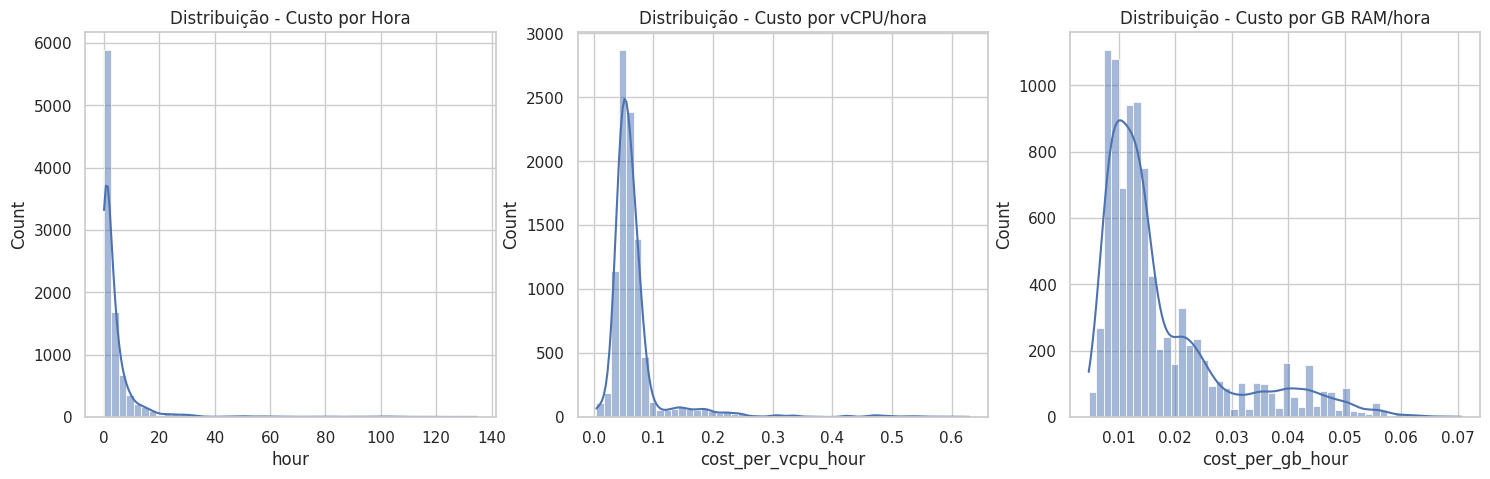

In [11]:
# =====================================
# 5. EDA - Distribuições
# =====================================
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(df_proc["hour"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribuição - Custo por Hora")

sns.histplot(df_proc["cost_per_vcpu_hour"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribuição - Custo por vCPU/hora")

sns.histplot(df_proc["cost_per_gb_hour"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Distribuição - Custo por GB RAM/hora")

plt.show()


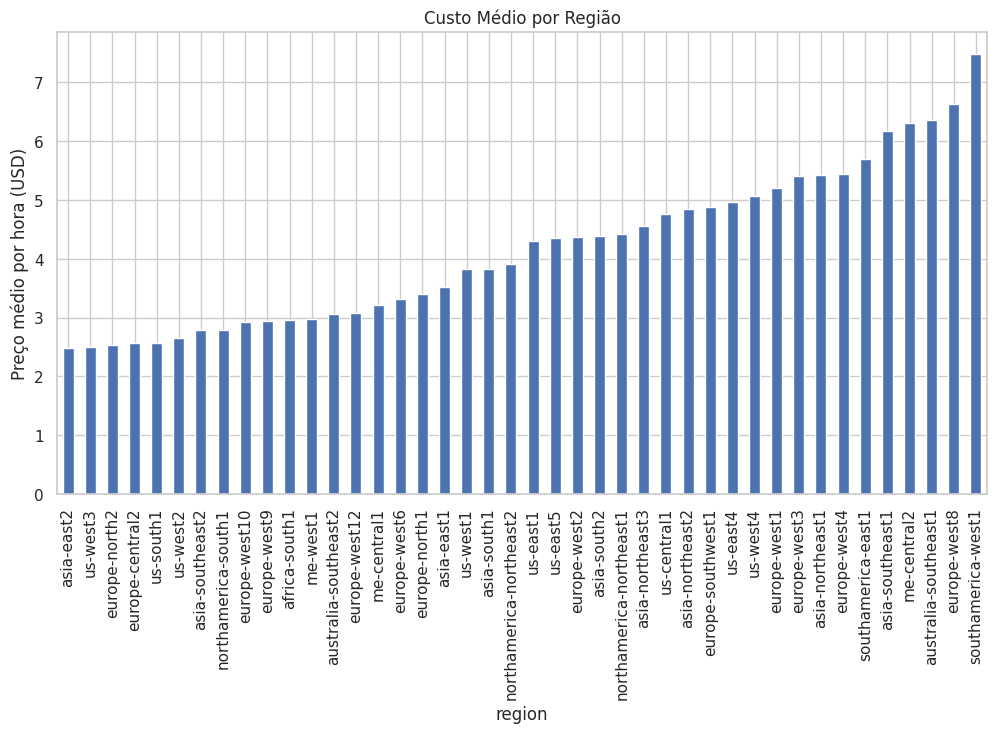

In [12]:
# =====================================
# 6. Custo Médio por Região
# =====================================
plt.figure(figsize=(12,6))
df_proc.groupby("region")["hour"].mean().sort_values().plot(kind="bar")
plt.title("Custo Médio por Região")
plt.ylabel("Preço médio por hora (USD)")
plt.show()


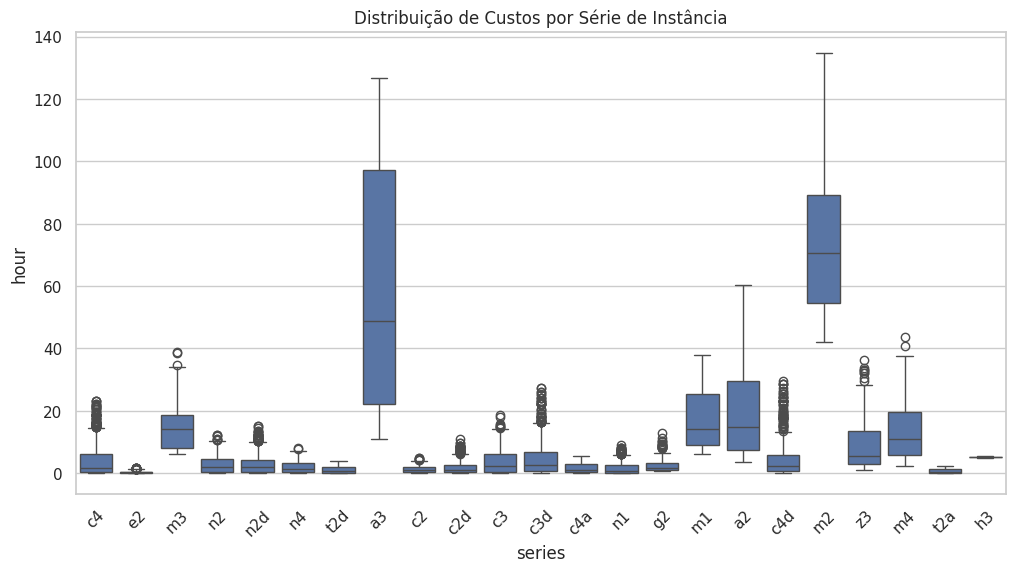

In [13]:
# =====================================
# 7. Boxplot por Série de Instância
# =====================================
plt.figure(figsize=(12,6))
sns.boxplot(data=df_proc, x="series", y="hour")
plt.title("Distribuição de Custos por Série de Instância")
plt.xticks(rotation=45)
plt.show()


## 📊 Distribuições de Custo (Hora, vCPU, GB RAM)

O primeiro conjunto de gráficos mostra como os custos estão distribuídos:

- **Custo por Hora:** a maioria das instâncias custa pouco (próximo de 0 a 10 USD/hora), mas há algumas poucas muito caras, criando uma cauda longa.  
- **Custo por vCPU/hora:** a distribuição é mais concentrada, com um pico entre 0.05 e 0.1 USD, sugerindo que a precificação por vCPU é relativamente padronizada.  
- **Custo por GB RAM/hora:** os valores ficam em torno de 0.01 a 0.02 USD/GB/hora, com menor dispersão que o custo total por hora. Isso mostra que memória é mais barata e previsível em relação a CPU.  

---

## 🌍 Custo Médio por Região

O gráfico de barras compara o custo médio por hora em diferentes regiões:

- Algumas regiões, como **asia-east2** e **us-west3**, estão entre as mais baratas.  
- Já regiões como **southamerica-west1** e **australia-southeast1** aparecem no topo, sendo significativamente mais caras.  
- Isso reflete custos operacionais locais e demanda regional.  
- Para uma empresa, escolher a região correta pode significar uma economia substancial.  

---

## 🖥️ Boxplot de Custos por Série de Instância

O boxplot mostra a variação de custos entre diferentes séries de máquinas:

- Algumas séries, como **e2 e n1**, apresentam custos mais baixos e menos variáveis → boas opções para workloads padrão.  
- Outras, como **a2 e m2**, têm valores médios e máximos bem maiores → indicam instâncias de alta performance, mas com custo elevado.  
- Outliers aparecem em várias séries, mostrando que dentro de uma mesma família existem instâncias muito mais caras (provavelmente devido a configurações especiais).  

---

✅ **Resumo dos Insights:**  
- O custo por **hora total** tem grande dispersão, mas ao normalizar por **vCPU** e **GB RAM** fica mais previsível.  
- Há **grandes diferenças regionais**, o que pode influenciar diretamente a escolha de onde hospedar workloads.  
- As **famílias de instância** apresentam perfis distintos: algumas são estáveis e baratas, outras são premium com alta variabilidade de preço.  
